# Dự báo điện năng tiêu thụ của khách hàng


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import os
import joblib
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.optimizers import Adam
import pyodbc
import datetime

## Tải dữ liệu

In [8]:

# Kết nối SQL Server
conn = pyodbc.connect('DRIVER={SQL Server};SERVER=LAPTOP-K2A0A359\\SERVERCHAU;DATABASE=DWDienLuc;Trusted_Connection=yes;')

# Câu truy vấn SQL với PIVOT và điều kiện lọc nhóm khách hàng
query = """
SELECT *
FROM (
    SELECT 
        kh.MA_KHANG,
        FORMAT(hd.NGAY_PHANH, 'yyyy-MM') AS Thang,
        SUM(ft.DIEN_TTHU) AS DIEN_TTHU
    FROM Fact_TieuThu ft
    JOIN Dim_KhachHang kh ON ft.DimKhachHangId = kh.MA_KHANG
    JOIN Dim_HoaDon hd ON ft.Dim_HoaDonID = hd.ID_HDON
    WHERE hd.NGAY_PHANH >= '2022-01-01' 
      AND hd.NGAY_PHANH <= '2023-12-31'
      AND kh.NHOM_KHANG = N'Khách hàng bình thường'
    GROUP BY kh.MA_KHANG, FORMAT(hd.NGAY_PHANH, 'yyyy-MM')
) AS src
PIVOT (
    SUM(DIEN_TTHU)
    FOR Thang IN (
        [2022-01], [2022-02], [2022-03], [2022-04], [2022-05], [2022-06],
        [2022-07], [2022-08], [2022-09], [2022-10], [2022-11], [2022-12],
        [2023-01], [2023-02], [2023-03], [2023-04], [2023-05], [2023-06],
        [2023-07], [2023-08], [2023-09], [2023-10], [2023-11], [2023-12]
    )
) AS pivot_table
"""

# Thực hiện truy vấn và đọc kết quả vào DataFrame
df = pd.read_sql(query, conn)
conn.close()

df.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_10400\1321474743.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,MA_KHANG,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,...,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12
0,PP05000940386,97.0,104.0,76.0,98.0,98.0,111.0,99.0,103.0,93.0,...,63.0,75.0,87.0,104.0,91.0,99.0,99.0,NaN,116.0,70.0
1,PP05000941917,143.0,91.0,111.0,67.0,64.0,222.0,227.0,NaN,13.0,...,119.0,176.0,241.0,337.0,337.0,146.0,32.0,38.0,NaN,89.0
2,PP09000900971,428.0,305.0,480.0,446.0,427.0,447.0,330.0,387.0,314.0,...,186.0,226.0,288.0,353.0,69.0,1.0,37.0,NaN,NaN,189.0
3,PP05000999895,329.0,314.0,388.0,478.0,557.0,747.0,821.0,725.0,766.0,...,309.0,234.0,215.0,234.0,247.0,215.0,267.0,NaN,553.0,129.0
4,PP05000966548,174.0,165.0,148.0,182.0,184.0,282.0,320.0,294.0,308.0,...,168.0,250.0,263.0,340.0,357.0,392.0,433.0,338.0,NaN,422.0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287746 entries, 0 to 287745
Data columns (total 25 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   MA_KHANG  287746 non-null  object 
 1   2022-01   259132 non-null  float64
 2   2022-02   275826 non-null  float64
 3   2022-03   256231 non-null  float64
 4   2022-04   247566 non-null  float64
 5   2022-05   228023 non-null  float64
 6   2022-06   281335 non-null  float64
 7   2022-07   278373 non-null  float64
 8   2022-08   249221 non-null  float64
 9   2022-09   284051 non-null  float64
 10  2022-10   283615 non-null  float64
 11  2022-11   253136 non-null  float64
 12  2022-12   285006 non-null  float64
 13  2023-01   269805 non-null  float64
 14  2023-02   284514 non-null  float64
 15  2023-03   281806 non-null  float64
 16  2023-04   283568 non-null  float64
 17  2023-05   284562 non-null  float64
 18  2023-06   284556 non-null  float64
 19  2023-07   284330 non-null  float64
 20  2023

## Xử lý dữ liệu

### Kiểm tra dữ liệu thiếu

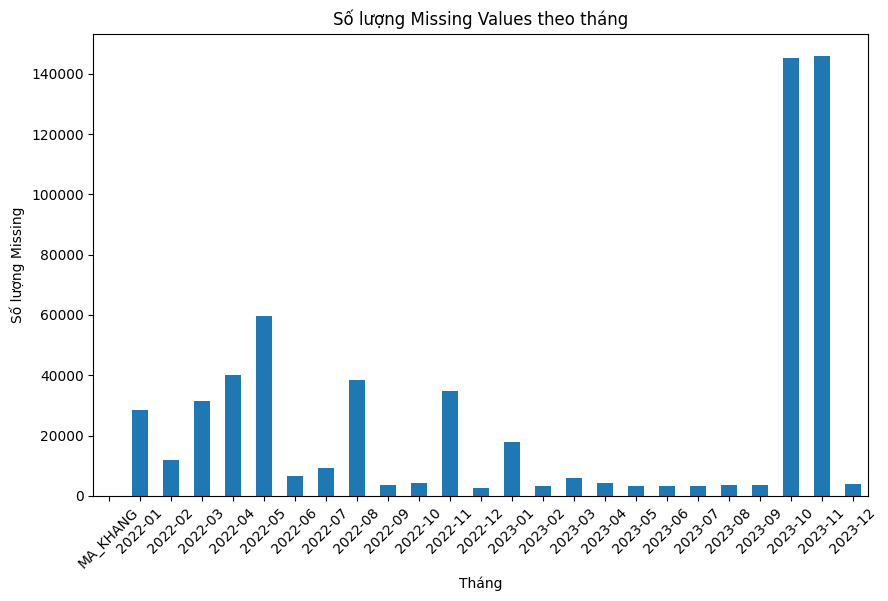

Số lượng khách hàng bị loại bỏ do có > 40% missing values: 3261


In [9]:
# Kiểm tra missing values theo cột (tháng)
missing_values = df.isna().sum()
plt.figure(figsize=(10,6))
missing_values.plot(kind='bar')
plt.title('Số lượng Missing Values theo tháng')
plt.xlabel('Tháng')
plt.ylabel('Số lượng Missing')
plt.xticks(rotation=45)
plt.show()

# Loại bỏ khách hàng có hơn 40% dữ liệu bị thiếu
missing_percent = df.isna().mean(axis=1)
df_filtered = df[missing_percent <= 0.4]

# Thống kê số lượng khách hàng bị loại bỏ
total_before = df.shape[0]
total_after = df_filtered.shape[0]
num_dropped = total_before - total_after
print(f"Số lượng khách hàng bị loại bỏ do có > 40% missing values: {num_dropped}")

### Xử lý dữ liệu thiếu: chỉ nội suy nếu phía trước đã có giá trị thực

In [10]:
min_valid_months = 12
# Hàm forward fill chỉ khi có giá trị trước đó
def forward_fill_only_if_prev(row):
    row_interp = row.copy()
    for i in range(len(row_interp)):
        if pd.isna(row_interp.iloc[i]):
            prev_vals = row_interp.iloc[:i]
            if prev_vals.notna().any():
                last_valid = prev_vals[prev_vals.notna()].iloc[-1]
                row_interp.iloc[i] = last_valid
    return row_interp
# Lấy danh sách các cột trừ 'MA_KHANG' để xử lý chuỗi thời gia
cols = [c for c in df_filtered.columns if c != 'MA_KHANG']
processed_rows = []
for idx, row in df_filtered[cols].iterrows():
    processed = forward_fill_only_if_prev(row.copy())
    if processed.notna().sum() >= min_valid_months:
        processed_rows.append(processed)

df_time_ready = pd.DataFrame(processed_rows, columns=cols)

# Chuyển đổi lại thành DataFrame với MA_KHANG
if 'MA_KHANG' in df_filtered.columns:
    df_time_ready['MA_KHANG'] = df_filtered.loc[df_time_ready.index, 'MA_KHANG'].values
print(f'Số khách hàng còn lại sau xử lý: {df_time_ready.shape[0]}')

Số khách hàng còn lại sau xử lý: 284485


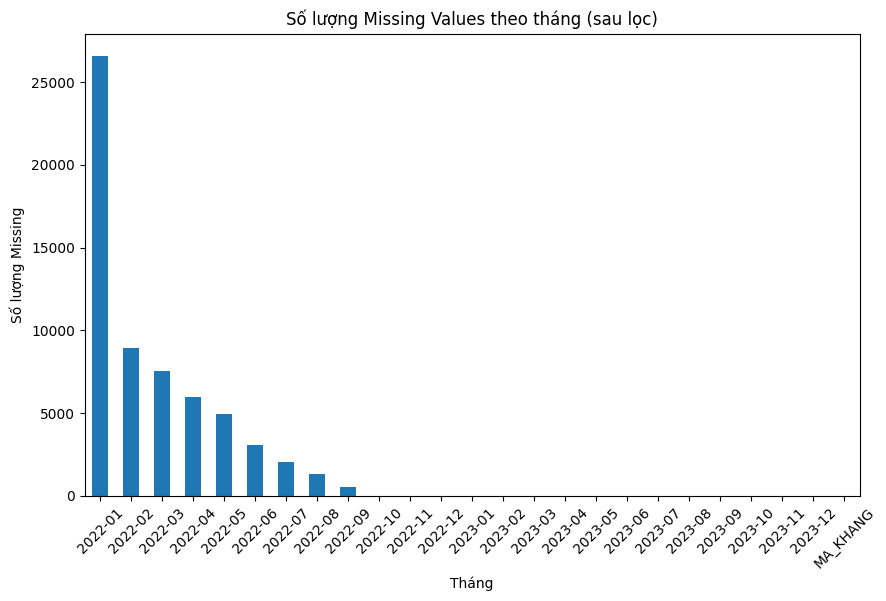

In [20]:
# Kiểm tra missing values sau khi lọc
missing_values = df_time_ready.isna().sum()
plt.figure(figsize=(10,6))
missing_values.plot(kind='bar')
plt.title('Số lượng Missing Values theo tháng (sau lọc)')
plt.xlabel('Tháng')
plt.ylabel('Số lượng Missing')
plt.xticks(rotation=45)
plt.show()

### Xử lý outlier bằng IQR

Đã loại 17092 khách hàng (6.01%) — còn lại 267393/284485


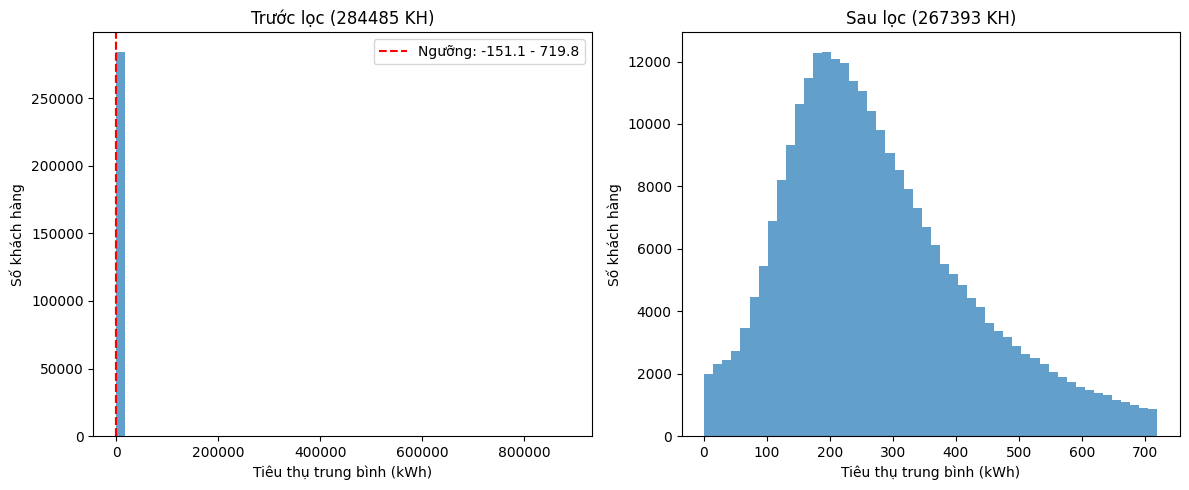

In [11]:
# Xử lý outlier dựa trên giá trị tiêu thụ trung bình của khách hàng
has_id = 'MA_KHANG' in df_time_ready.columns
means = df_time_ready.drop(columns='MA_KHANG') if has_id else df_time_ready
customer_means = means.mean(axis=1)

# Xác định ngưỡng outlier
Q1, Q3 = customer_means.quantile([0.25, 0.75])
IQR = Q3 - Q1
low, high = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
outliers = (customer_means < low) | (customer_means > high)

# Loại bỏ outlier
before, after = len(df_time_ready), (~outliers).sum()
df_time_ready = df_time_ready.loc[~outliers].copy()

print(f"Đã loại {before - after} khách hàng ({(before - after)/before:.2%}) — còn lại {after}/{before}")

# Trực quan hóa phân phối trước và sau
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(customer_means, bins=50, alpha=0.7)
axes[0].axvline(low, color='red', linestyle='--', label=f'Ngưỡng: {low:.1f} - {high:.1f}')
axes[0].axvline(high, color='red', linestyle='--')
axes[0].set_title(f'Trước lọc ({before} KH)'); axes[0].legend()

axes[1].hist(df_time_ready.drop(columns='MA_KHANG').mean(axis=1) if has_id else df_time_ready.mean(axis=1), bins=50, alpha=0.7)
axes[1].set_title(f'Sau lọc ({after} KH)')

for ax in axes: ax.set_xlabel('Tiêu thụ trung bình (kWh)'); ax.set_ylabel('Số khách hàng')
plt.tight_layout(); plt.show()


### Phân tích chuỗi thời gian và kiểm tra tính dừng

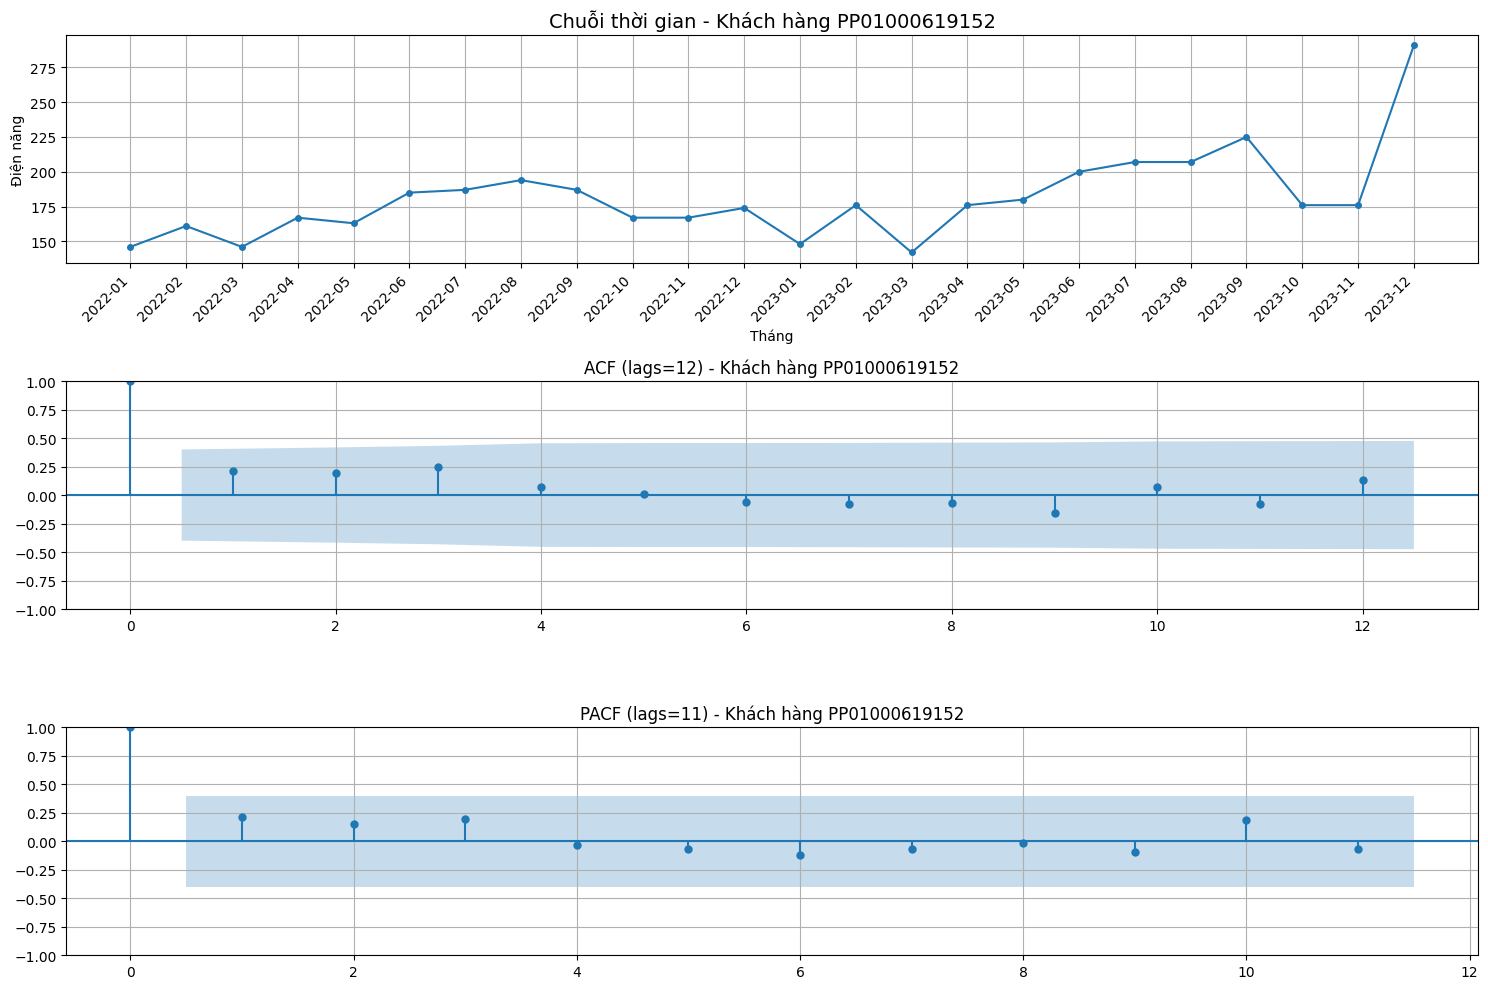

[ADF Test] Khách hàng PP01000619152
ADF Statistic: 0.282921
p-value: 0.976547
Critical Values:
  1%: -4.012034
  5%: -3.104184
  10%: -2.690987
Kết luận: Không ổn định (95%)



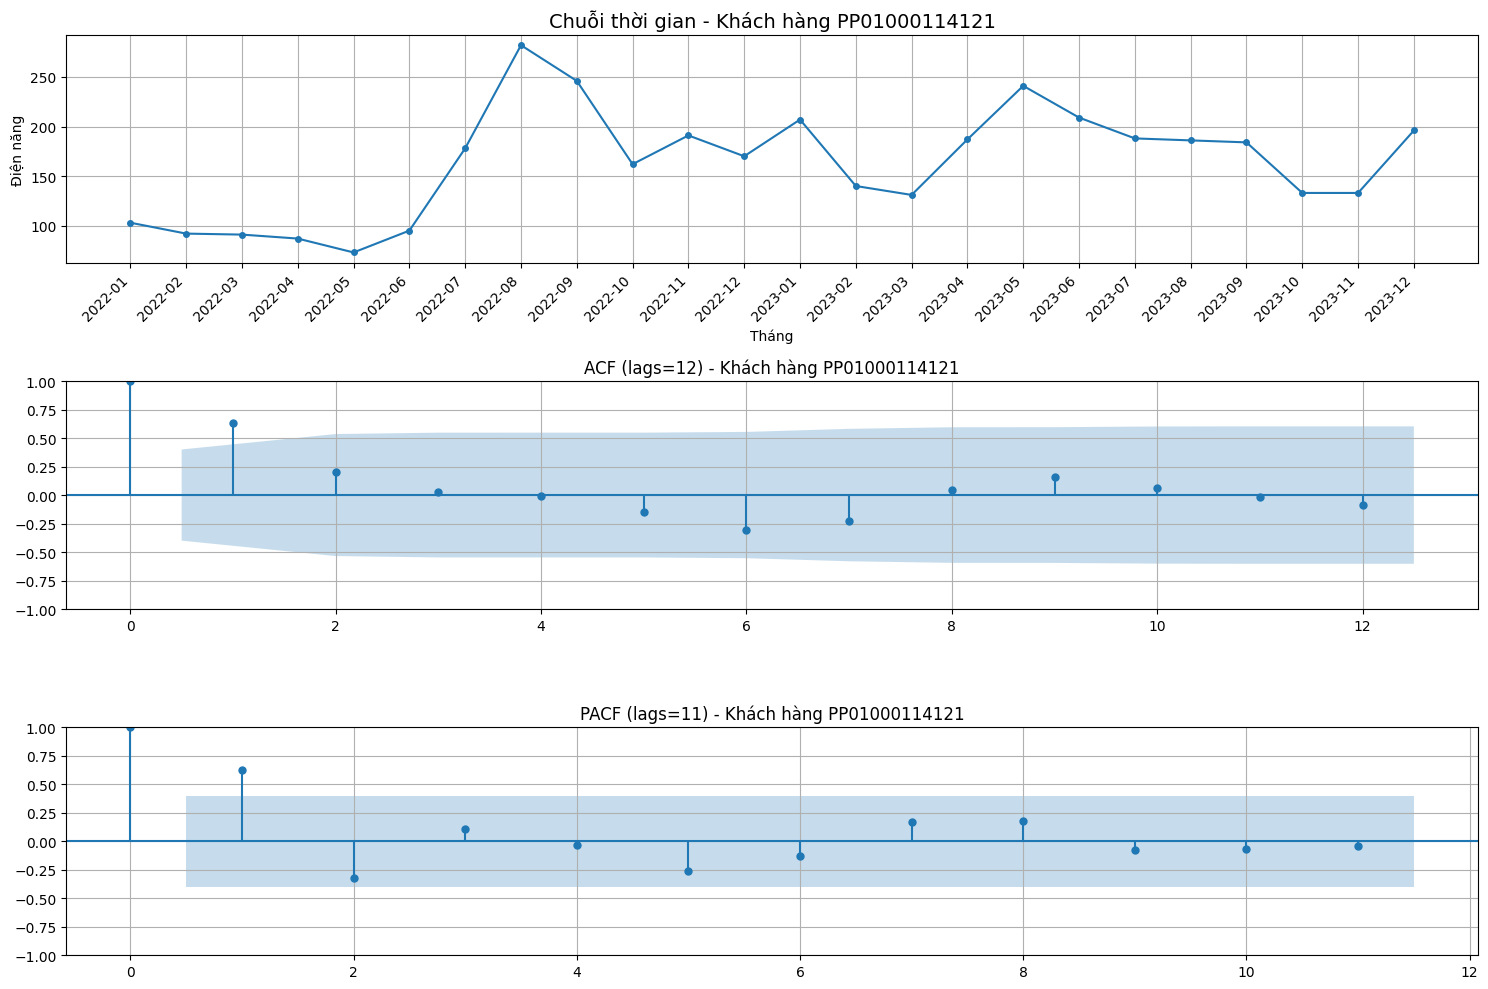

[ADF Test] Khách hàng PP01000114121
ADF Statistic: -4.385409
p-value: 0.000315
Critical Values:
  1%: -3.889266
  5%: -3.054358
  10%: -2.666984
Kết luận: Ổn định (95%)



In [8]:
def analyze_time_series_customer(data, customer_idx=0, lags=12):
    row = data.iloc[customer_idx]
    customer_id = row.get('MA_KHANG', f"#{customer_idx}")
    series = row.drop('MA_KHANG') if 'MA_KHANG' in row else row
    series = pd.Series(series.to_numpy(), index=series.index.astype(str)).dropna()

    lags_acf = min(lags, len(series) - 1)
    lags_pacf = min(lags, max(1, (len(series) // 2) - 1))

    fig, axes = plt.subplots(3, 1, figsize=(15, 10))
    axes[0].plot(series, marker='o', linestyle='-', markersize=4)
    axes[0].set_title(f'Chuỗi thời gian - Khách hàng {customer_id}', fontsize=14)
    axes[0].set_xlabel('Tháng')
    axes[0].set_ylabel('Điện năng')
    axes[0].grid(True)
    plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')

    plot_acf(series, lags=lags_acf, ax=axes[1])
    axes[1].set_title(f'ACF (lags={lags_acf}) - Khách hàng {customer_id}')
    axes[1].grid(True)

    plot_pacf(series, lags=lags_pacf, ax=axes[2])
    axes[2].set_title(f'PACF (lags={lags_pacf}) - Khách hàng {customer_id}')
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

    adf_stat, p_value, _, _, crit_vals, _ = adfuller(series)
    print(f"[ADF Test] Khách hàng {customer_id}")
    print(f"ADF Statistic: {adf_stat:.6f}")
    print(f"p-value: {p_value:.6f}")
    print("Critical Values:")
    for k, v in crit_vals.items():
        print(f"  {k}: {v:.6f}")
    print("Kết luận:", "Ổn định" if p_value < 0.05 else "Không ổn định", "(95%)\n")

    return series


# Phân tích 2 khách hàng đầu
for i in range(min(2, len(df_time_ready))):
    analyze_time_series_customer(df_time_ready, customer_idx=i, lags=12)


### Chuẩn bị dữ liệu cho LSTM

In [9]:
def prepare_time_series_data(df, window_size=12, test_size=0.2, scale=True):
    if 'MA_KHANG' in df.columns:
        data = df.drop(columns=['MA_KHANG'])
    else:
        data = df.copy()
    # Kiểm tra và xử lý NaN trong dữ liệu
    if data.isna().any().any():
        print("Cảnh báo: Dữ liệu vẫn còn chứa giá trị NaN. Thực hiện điền khuyết bổ sung.")
        data = data.fillna(method='ffill').fillna(method='bfill').fillna(0)
    # Chuẩn hóa dữ liệu về đoạn [0, 1] bằng MinMaxScaler
    if scale:
        scaler = MinMaxScaler(feature_range=(0, 1))
        data_scaled = scaler.fit_transform(data)
    else:
        data_scaled = data.values
        scaler = None
    # Kiểm tra và xử lý giá trị vô cùng
    if np.isinf(data_scaled).any():
        print("Cảnh báo: Phát hiện giá trị vô cùng. Thay thế bằng giá trị hữu hạn.")
        data_scaled = np.nan_to_num(data_scaled, posinf=1e6, neginf=-1e6)
    # Khởi tạo danh sách để chứa các cửa sổ dữ liệu (X) và giá trị mục tiêu (y)
    X, y = [], []
    n_samples, n_features = data_scaled.shape
    # Tạo các cửa sổ dữ liệu có kích thước window_size cho từng khách hàng
    for i in range(n_samples):
        customer_data = data_scaled[i, :]
        for j in range(len(customer_data) - window_size):
            X.append(customer_data[j:j+window_size])
            y.append(customer_data[j+window_size])
    # Chuyển đổi danh sách thành mảng NumPy         
    X = np.array(X)
    y = np.array(y)
    # Kiểm tra lần cuối trước khi phân chia tập dữ liệu
    if np.isnan(X).any() or np.isinf(X).any() or np.isnan(y).any() or np.isinf(y).any():
        print("Cảnh báo: Dữ liệu vẫn chứa NaN/Inf. Xử lý lần cuối.")
        X = np.nan_to_num(X)
        y = np.nan_to_num(y)

    # Chia dữ liệu thành tập huấn luyện và tập kiểm tra
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    print(f"Kích thước dữ liệu:")
    print(f"X_train: {X_train.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"X_test: {X_test.shape}")
    print(f"y_test: {y_test.shape}")
    return X_train, X_test, y_train, y_test, scaler

window_size = 12
X_train, X_test, y_train, y_test, scaler = prepare_time_series_data(df_time_ready, window_size=window_size)

Cảnh báo: Dữ liệu vẫn còn chứa giá trị NaN. Thực hiện điền khuyết bổ sung.


C:\Users\Admin\AppData\Local\Temp\ipykernel_1072\1310461474.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill').fillna(0)


Kích thước dữ liệu:
X_train: (2518300, 12, 1)
y_train: (2518300,)
X_test: (629576, 12, 1)
y_test: (629576,)


## Xây dựng và huấn luyện mô hình LSTM

### Xây dựng mô hình dự báo LSTM

In [ ]:
# Hàm xây dựng mô hình LSTM
def build_lstm_model(input_shape, lstm_units=64, dropout_rate=0.2, use_bidirectional=True, use_batchnorm=True):
    model = Sequential()
    if use_bidirectional:
        model.add(Bidirectional(LSTM(lstm_units, return_sequences=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal'), input_shape=input_shape))
    else:
        model.add(LSTM(lstm_units, return_sequences=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', input_shape=input_shape))
    if use_batchnorm:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    if use_bidirectional:
        model.add(Bidirectional(LSTM(lstm_units // 2, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal')))
    else:
        model.add(LSTM(lstm_units // 2, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal'))
    if use_batchnorm:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    
    # Sử dụng learning rate nhỏ và thêm gradient clipping
    from tensorflow.keras.optimizers import Adam
    optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Kiểm tra dữ liệu trước khi huấn luyện
print("Kiểm tra NaN trong tập huấn luyện:", np.isnan(X_train).any())
print("Kiểm tra Infinity trong tập huấn luyện:", np.isinf(X_train).any())

# Xác định input_shape cho mô hình từ kích thước dữ liệu huấn luyện (số bước thời gian, số đặc trưng)
input_shape = (X_train.shape[1], X_train.shape[2])
# Xây dựng mô hình với 64 đơn vị LSTM, dropout 0.3, sử dụng LSTM hai chiều
model = build_lstm_model(input_shape, lstm_units=64, dropout_rate=0.3, use_bidirectional=True)
model.summary()

Kiểm tra NaN trong tập huấn luyện: False
Kiểm tra Infinity trong tập huấn luyện: False


d:\cuối\Python\myenv\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 12, 128)        │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,841 (296.25 KB)

 Trainable params: 75,457 (294.75 KB)

 Non-trainable params: 384 (1.50 KB)

### Huấn luyện mô hình LSTM và theo dõi quá trình học

✅ Dữ liệu không chứa NaN hoặc giá trị vô cùng.
Epoch 1/10
31479/31479 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0227 - mae: 0.0494
Epoch 1: val_loss improved from inf to 0.00050, saving model to models/lstm_best_model3.h5


31479/31479 ━━━━━━━━━━━━━━━━━━━━ 732s 23ms/step - loss: 0.0227 - mae: 0.0494 - val_loss: 4.9858e-04 - val_mae: 0.0136 - learning_rate: 0.0010
Epoch 2/10
31477/31479 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 5.7886e-04 - mae: 0.0156
Epoch 2: val_loss improved from 0.00050 to 0.00050, saving model to models/lstm_best_model3.h5


31479/31479 ━━━━━━━━━━━━━━━━━━━━ 689s 22ms/step - loss: 5.7886e-04 - mae: 0.0156 - val_loss: 4.9812e-04 - val_mae: 0.0143 - learning_rate: 0.0010
Epoch 3/10
31477/31479 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.4136e-04 - mae: 0.0150
Epoch 3: val_loss improved from 0.00050 to 0.00044, saving model to models/lstm_best_model3.h5


31479/31479 ━━━━━━━━━━━━━━━━━━━━ 619s 20ms/step - loss: 5.4136e-04 - mae: 0.0150 - val_loss: 4.4147e-04 - val_mae: 0.0121 - learning_rate: 0.0010
Epoch 4/10
31478/31479 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.3558e-04 - mae: 0.0148
Epoch 4: val_loss improved from 0.00044 to 0.00044, saving model to models/lstm_best_model3.h5


31479/31479 ━━━━━━━━━━━━━━━━━━━━ 606s 19ms/step - loss: 5.3558e-04 - mae: 0.0148 - val_loss: 4.3578e-04 - val_mae: 0.0120 - learning_rate: 0.0010
Epoch 5/10
31478/31479 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.3545e-04 - mae: 0.0147
Epoch 5: val_loss did not improve from 0.00044
31479/31479 ━━━━━━━━━━━━━━━━━━━━ 613s 19ms/step - loss: 5.3545e-04 - mae: 0.0147 - val_loss: 4.4546e-04 - val_mae: 0.0124 - learning_rate: 0.0010
Epoch 6/10
31478/31479 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.2086e-04 - mae: 0.0146
Epoch 6: val_loss did not improve from 0.00044

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
31479/31479 ━━━━━━━━━━━━━━━━━━━━ 609s 19ms/step - loss: 5.2086e-04 - mae: 0.0146 - val_loss: 5.3614e-04 - val_mae: 0.0164 - learning_rate: 0.0010
Epoch 7/10
31477/31479 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.9684e-04 - mae: 0.0141
Epoch 7: val_loss improved from 0.00044 to 0.00042, saving model to models/lstm_best_model3.h5


31479/31479 ━━━━━━━━━━━━━━━━━━━━ 621s 20ms/step - loss: 4.9684e-04 - mae: 0.0141 - val_loss: 4.1765e-04 - val_mae: 0.0119 - learning_rate: 2.0000e-04
Epoch 8/10
31478/31479 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.9176e-04 - mae: 0.0140
Epoch 8: val_loss improved from 0.00042 to 0.00041, saving model to models/lstm_best_model3.h5


31479/31479 ━━━━━━━━━━━━━━━━━━━━ 600s 19ms/step - loss: 4.9176e-04 - mae: 0.0140 - val_loss: 4.1432e-04 - val_mae: 0.0114 - learning_rate: 2.0000e-04
Epoch 9/10
31478/31479 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.9108e-04 - mae: 0.0139
Epoch 9: val_loss did not improve from 0.00041
31479/31479 ━━━━━━━━━━━━━━━━━━━━ 591s 19ms/step - loss: 4.9108e-04 - mae: 0.0139 - val_loss: 4.2062e-04 - val_mae: 0.0116 - learning_rate: 2.0000e-04
Epoch 10/10
31479/31479 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.8878e-04 - mae: 0.0139
Epoch 10: val_loss improved from 0.00041 to 0.00041, saving model to models/lstm_best_model3.h5


31479/31479 ━━━━━━━━━━━━━━━━━━━━ 606s 19ms/step - loss: 4.8878e-04 - mae: 0.0139 - val_loss: 4.1109e-04 - val_mae: 0.0113 - learning_rate: 2.0000e-04
Restoring model weights from the end of the best epoch: 10.


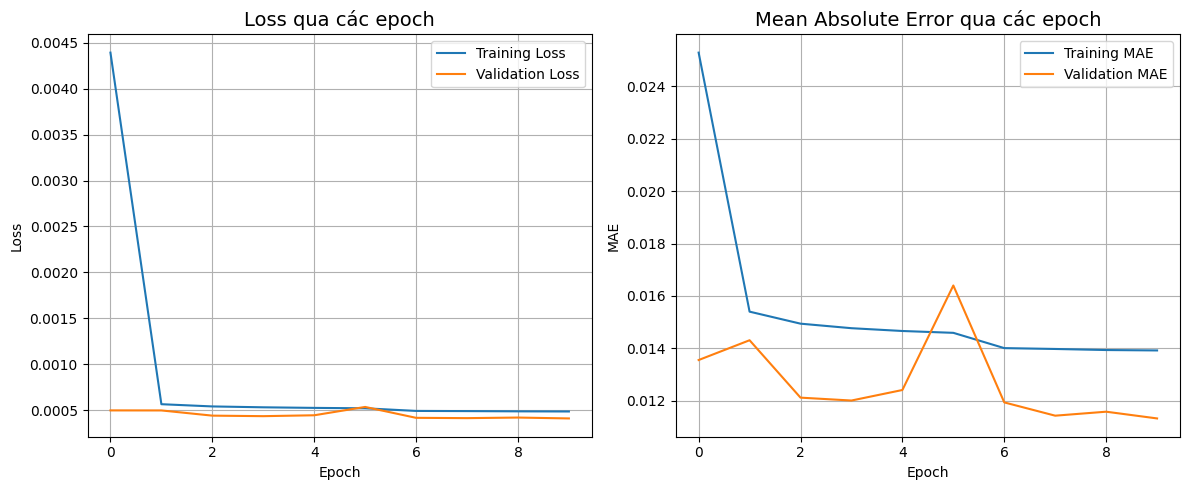

In [11]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN

# --- Kiểm tra và xử lý dữ liệu NaN/inf ---
def check_and_clean_data(X_train, X_test, y_train, y_test):
    if np.isnan(X_train).any() or np.isinf(X_train).any() or \
       np.isnan(X_test).any() or np.isinf(X_test).any() or \
       np.isnan(y_train).any() or np.isinf(y_train).any() or \
       np.isnan(y_test).any() or np.isinf(y_test).any():
        print("⚠️ Cảnh báo: Dữ liệu chứa NaN hoặc giá trị vô cùng. Đang tiến hành xử lý...")
        X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
        X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)
        y_train = np.nan_to_num(y_train, nan=0.0, posinf=0.0, neginf=0.0)
        y_test = np.nan_to_num(y_test, nan=0.0, posinf=0.0, neginf=0.0)
        print("✅ Đã xử lý xong NaN/inf.")
    else:
        print("✅ Dữ liệu không chứa NaN hoặc giá trị vô cùng.")
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = check_and_clean_data(X_train, X_test, y_train, y_test)

# --- Thiết lập thư mục lưu mô hình ---
os.makedirs('models', exist_ok=True)

# --- Callback ---
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('models/lstm_best_model3.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-4, verbose=1)
terminate_on_nan = TerminateOnNaN()

# --- Huấn luyện mô hình ---
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint, reduce_lr, terminate_on_nan],
    verbose=1
)

# --- Vẽ biểu đồ loss & MAE ---
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss qua các epoch', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Mean Absolute Error qua các epoch', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)


## Đánh giá mô hình và lưu mô hình

In [12]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

# Sử dụng cách tính RMSE tương thích với mọi phiên bản scikit-learn
try:
    rmse = mean_squared_error(y_test, y_pred, squared=False)
except TypeError:
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

# Lưu mô hình và scaler để sử dụng sau
model.save('models/lstm_best_model3.h5')
joblib.dump(scaler, 'models/scaler3.save')

# Lưu thông tin window_size để sử dụng sau này
with open('models/config3.txt', 'w') as f:
    f.write(f"window_size={window_size}")
print("\nĐã lưu mô hình và cấu hình vào thư mục 'models/'")

19675/19675 ━━━━━━━━━━━━━━━━━━━━ 96s 5ms/step


MAE: 0.0113
RMSE: 0.0200
R2: 0.8760

Đã lưu mô hình và cấu hình vào thư mục 'models/'


## Dự báo điện năng tiêu thụ cho khách hàng theo mã khách hàng

Chỉ cần nhập mã khách hàng vào biến `customer_id` dưới đây và chạy cell để lấy dự báo.

In [5]:
def predict_customer_consumption(customer_code):
    """Dự báo điện năng tiêu thụ cho khách hàng dựa vào mã khách hàng."""

    # Tải mô hình và scaler
    model = load_model('models/lstm_best_model3.h5', compile=False)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    scaler = joblib.load('models/scaler3.save')

    # Cấu hình window size
    try:
        with open('models/config3.txt', 'r') as f:
            window_size = int(f.read().split('=')[1])
    except:
        window_size = 12

    # Lấy dữ liệu khách hàng
    if customer_code not in df_time_ready['MA_KHANG'].values:
        print(f"❌ Không tìm thấy mã KH: {customer_code}")
        return None
    customer_data = df_time_ready[df_time_ready['MA_KHANG'] == customer_code].drop(columns=['MA_KHANG']).iloc[0]
    values = customer_data.values.astype(float)
    values = np.nan_to_num(values, nan=np.nanmean(values))

    # Thống kê cơ bản
    mean_val, std_val = np.mean(values[values > 0]), np.std(values[values > 0])
    last_val = next((v for v in reversed(values) if v > 0), mean_val)
    max_val = np.max(values)

    # Chuẩn hóa và dự báo
    scaled = scaler.transform(values.reshape(1, -1))
    input_seq = scaled[0, -window_size:].reshape(1, window_size, 1)
    pred_scaled = model.predict(input_seq, verbose=0)[0, 0]
    pred_real = scaler.inverse_transform([[pred_scaled] + [0]*(values.size - 1)])[0, 0]

    # Điều chỉnh mùa vụ
    month_idx = (np.argmax(values[::-1] > 0) + 1) % 12
    seasonal = 1.15 if 5 <= month_idx <= 9 else 1.0
    pred_real *= seasonal

    # Điều chỉnh giới hạn
    final_pred = np.clip(pred_real, mean_val * 0.8, max(mean_val * 1.5, last_val * 2.0))

    # Vẽ biểu đồ
    months = customer_data.index.astype(str)
    plt.figure(figsize=(15, 7))
    plt.plot(months, values, 'o-', label='Lịch sử')
    plt.plot([months[-1], 'Dự báo'], [values[-1], final_pred], 'ro--', label='Dự báo')
    plt.axhline(mean_val, color='green', linestyle='--', label=f'Trung bình ({mean_val:.1f})')
    plt.text(len(months), final_pred + 5, f'{final_pred:.1f} kWh',
                ha='center', fontsize=12, color='black')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(f"🔶 Dự báo tháng tới: {final_pred:.2f} kWh")
    return final_pred


In [6]:
# Thử nghiệm với khách hàng
predict_customer_consumption('PP07000701228')

NameError: name 'df_time_ready' is not defined